## [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)

"The t-test is any statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis."

Suppose $X$ follows a normal distribution $N(\mu, \sigma^2)$.  If $\mu$ is assumed and $\sigma^2$ is estimated as $S^2 = \frac{1}{N-1}\sum{(X_i - \bar{X})^2}$, then $T(X) = \frac{\bar{X} - \mu}{S/\sqrt{N}}$ follows a t-distribution with $N-1$ degrees of freedom.

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Data shape: (344, 7) <class 'pandas.core.frame.DataFrame'>


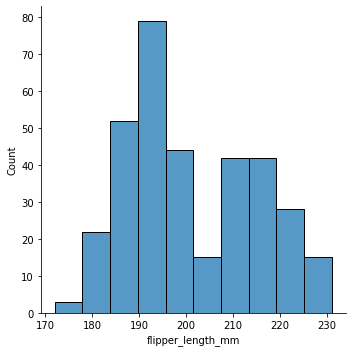

In [3]:
penguins = sns.load_dataset("penguins")
print('Data shape:', penguins.shape, type(penguins))
sns.displot(penguins, x="flipper_length_mm")

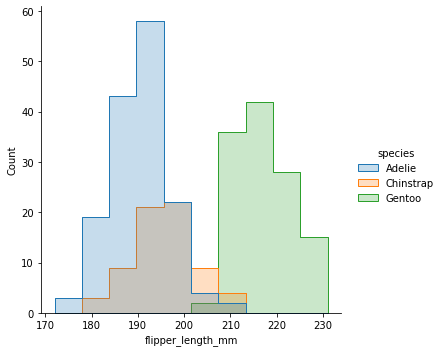

In [4]:
sns.displot(penguins, x="flipper_length_mm", hue="species", element="step")